# Advanced Cell State Analysis

This notebook processes battery test data to create advanced state classifications for battery cells. It analyzes current and voltage derivatives to classify different charging/discharging states and creates time-based intervals for analysis.

## Overview
1. Load and process battery data from JSON files
2. Calculate current and voltage derivatives with relaxed sign functions
3. Classify battery states (REST, CHARGE_CC, CHARGE_CV, etc.)
4. Create continuous time intervals for each state
5. Generate pandas DataFrames for further analysis
6. Calculate average current and voltage for each interval

In [33]:
# Import required libraries
from json import load, dump  # For loading and saving JSON data
from add_fields_functions import find_state  # Custom functions for derivative calculations and relaxed sign
import matplotlib.pyplot as plt  # For plotting visualizations

## Step 1: Data Loading
Load the preprocessed battery data from the JSON file containing all checkup measurements.

In [34]:
# Load the full dataset from JSON file
# This contains all battery measurements organized by checkup (CU000, CU001, etc.)
with open("full_data.json", "r") as f:
    dataset = load(f)

In [35]:
# Display available checkup names in the dataset
# These are typically named CU000, CU001, CU002, etc.
dataset.keys()

dict_keys(['CU000', 'CU001', 'CU002', 'CU003', 'CU004', 'CU005', 'CU006', 'CU007', 'CU008', 'CU009', 'CU010', 'CU011'])

## Step 2: Advanced State Classification
Calculate derivatives of current (I) and voltage (U) to classify battery states more precisely.

**State Classifications:**
- **REST**: Battery is at pause/rest
- **CHARGE_CC**: Constant current charging (current derivative ≈ 0)
- **CHARGE_CV**: Constant voltage charging (voltage derivative ≈ 0)  
- **CHARGE_DYNAMIC**: Dynamic charging (both current and voltage changing)
- **DISCHARGE_CC**: Constant current discharging
- **DISCHARGE_CV**: Constant voltage discharging
- **DISCHARGE_DYNAMIC**: Dynamic discharging

In [36]:
advanced_state = find_state(dataset)

CU000 OK
CU001 OK
CU002 OK
CU003 OK
CU002 OK
CU003 OK
CU004 OK
CU005 OK
CU004 OK
CU005 OK
CU006 OK
CU007 OK
CU006 OK
CU007 OK
CU008 OK
CU009 OK
CU008 OK
CU009 OK
CU010 OK
CU011 OK
CU010 OK
CU011 OK


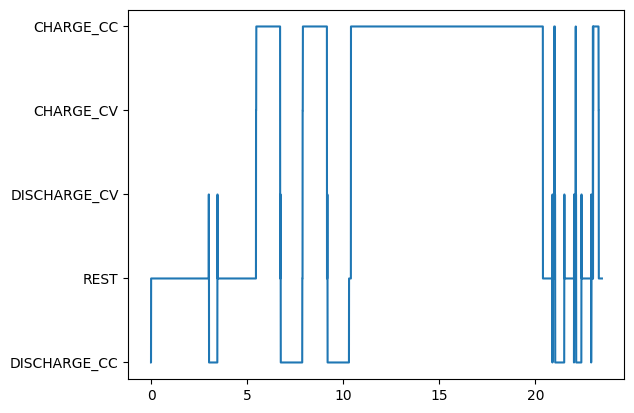

In [37]:
# Visualize the advanced state classification for CU000 over time
# This shows how the battery state changes throughout the test
plt.plot(dataset["CU000"]["Time"], advanced_state["CU000"])

In [38]:
# Save the advanced state classifications to a JSON file for future use
with open("advanced_state.json", "w") as f:
    dump(advanced_state, f)

## Step 3: Create Continuous Time Intervals
Convert the point-by-point state classifications into time intervals where each state persists. This compresses the data from individual time points to continuous periods.

In [39]:
# Dictionary to store continuous time intervals for each checkup
continuous = {}

# Process each checkup to create time intervals
for checkup_name in advanced_state:
    # Initialize with the first time point and first state
    continuous[checkup_name] = {
        "time_periods": [dataset[checkup_name]["Time"][0]],  # Start times of intervals
        "labels": [advanced_state[checkup_name][0]]  # State labels for intervals
    }
    
    # Iterate through all time points to detect state changes
    for i, time in enumerate(dataset[checkup_name]["Time"]):
        current_state = advanced_state[checkup_name][i]
        
        # If state hasn't changed, update the end time of current interval
        if current_state == continuous[checkup_name]["labels"][-1]:
            continuous[checkup_name]["time_periods"][-1] = time
        else:
            # State has changed - start a new interval
            continuous[checkup_name]["time_periods"].append(time)
            continuous[checkup_name]["labels"].append(current_state)

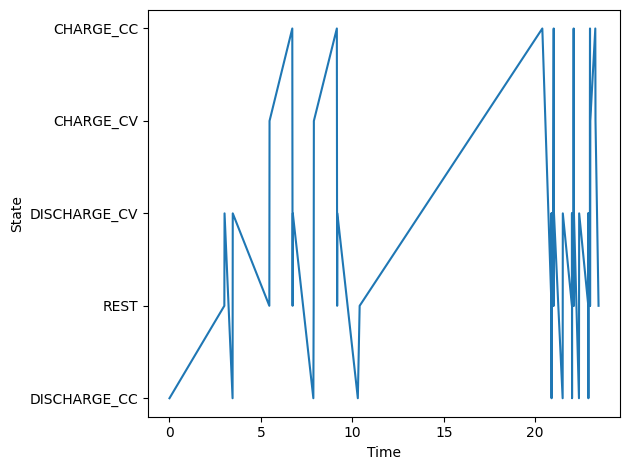

In [40]:
# Visualize the continuous intervals for CU000
# This shows the compressed representation of state changes over time
plt.plot(continuous["CU000"]["time_periods"], continuous["CU000"]["labels"])
plt.xlabel("Time")
plt.ylabel("State")
plt.tight_layout()
plt.show()

In [41]:
# Save the continuous interval data to a JSON file
with open("continuous_advanced_state.json", "w") as f:
    dump(continuous, f)

## Step 4: Create Pandas DataFrames
Convert the data into pandas DataFrames for easier analysis and manipulation. This includes:
1. Converting raw measurement data to DataFrames with time as index
2. Converting continuous intervals to DataFrames with start/end times and labels

In [42]:
import pandas as pd

# Dictionary to store DataFrames for each checkup's measurement data
dataset_dfs = {}

# Convert measurement data to pandas DataFrames
for key, value in dataset.items():
    try:
        # Create DataFrame excluding 'Time' and '_fieldnames' columns
        # Time will be used as the index instead of a column
        df = pd.DataFrame({k: v for k, v in value.items() if k != "Time" and k != "_fieldnames"})
        df.index = value["Time"]  # Set time as the index for easy time-based slicing
        dataset_dfs[key] = df
    except:
        # Skip any problematic checkups
        continue

In [43]:
# Dictionary to store DataFrames for continuous intervals
continuous_dfs = {}

# Convert continuous interval data to pandas DataFrames
for key, value in continuous.items():
    # Skip checkups that don't have corresponding measurement data
    if key not in dataset_dfs:
        continue
    
    # Create time intervals: [0, end_of_first_interval, end_of_second_interval, ...]
    time_periods = [0] + value["time_periods"]
    labels = value["labels"]
    
    # Create (start, end) tuples for each interval
    intervals = [(time_periods[i], time_periods[i + 1]) for i in range(len(time_periods)-1)]
    
    # Create DataFrame with start/end times and corresponding labels
    df = pd.DataFrame(intervals, columns=["start", "end"])
    df["label"] = labels  # Add state labels for each interval
    continuous_dfs[key] = df

In [44]:
# Display the continuous intervals DataFrame for CU000 as an example
continuous_dfs["CU000"]

,start,end,label
0,0.000000,0.000003,DISCHARGE_CC
1,0.000003,3.000036,REST
2,3.000036,3.011214,DISCHARGE_CV
3,3.011214,3.450103,DISCHARGE_CC
4,3.450103,3.460079,DISCHARGE_CV
5,3.460079,5.460112,REST
6,5.460112,5.471289,CHARGE_CV
7,5.471289,6.715617,CHARGE_CC
8,6.715617,6.732317,REST
9,6.732317,6.743524,DISCHARGE_CV


## Step 5: Calculate Average Values for Each Interval
For each time interval, calculate the average current (I) and voltage (U) values. This provides summary statistics for each state period.

In [45]:
# Calculate average current and voltage for each interval
for checkup, dataframe in continuous_dfs.items():
    # Lists to store average values for this checkup
    avg_I = []  # Average current for each interval
    avg_U = []  # Average voltage for each interval
    
    # Process each interval (row) in the dataframe
    for _, row in dataframe.iterrows():
        # Extract subset of measurement data for this time interval
        # Uses pandas .loc for label-based indexing with time
        sub_df = dataset_dfs[checkup].loc[row["start"]:row["end"]]
        
        # Calculate and store average values for this interval
        avg_I.append(sub_df["I"].mean())  # Mean current
        avg_U.append(sub_df["U"].mean())  # Mean voltage
    
    # Add the calculated averages as new columns to the dataframe
    dataframe["Avg_I"] = avg_I
    dataframe["Avg_U"] = avg_U

In [46]:
continuous_dfs["CU000"]

,start,end,label,Avg_I,Avg_U
0,0.000000,0.000003,DISCHARGE_CC,0.000000,3.708752
1,0.000003,3.000036,REST,0.000000,3.709333
2,3.000036,3.011214,DISCHARGE_CV,-1.785638,3.658936
3,3.011214,3.450103,DISCHARGE_CC,-2.499999,3.316382
4,3.450103,3.460079,DISCHARGE_CV,-2.499997,2.555095
5,3.460079,5.460112,REST,-0.003458,2.980802
6,5.460112,5.471289,CHARGE_CV,1.784581,3.147086
7,5.471289,6.715617,CHARGE_CC,1.922957,3.926315
8,6.715617,6.732317,REST,0.005506,4.198448
9,6.732317,6.743524,DISCHARGE_CV,-1.785664,4.144712


## Summary

This notebook successfully processes battery test data to create advanced state classifications:

1. **Loaded** battery measurement data from JSON files
2. **Calculated** current and voltage derivatives with smoothing
3. **Classified** battery states based on derivatives and commands
4. **Created** continuous time intervals for each state period
5. **Generated** pandas DataFrames for easy analysis
6. **Calculated** average current and voltage for each interval

The final output includes DataFrames with:
- Time intervals (start/end)
- State classifications
- Average current and voltage values

This processed data can now be used for further analysis, visualization, or machine learning applications.